# Clustering ROSMAP scRNA data



In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

/Users/subhajit/miniconda3/envs/scRNA_test/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.6 anndata==0.7.1 umap==0.4.1 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [126]:
results_file = './output/rosmap_scRNA_fil.h5ad'  # the file that will store the analysis results

In [15]:
adata = sc.read_10x_mtx(
    '/Users/subhajit/Desktop/ToDo/CPG/JD/ROSMAP/scRNASeq_test/ROSMAP_scRNA_data/Processed/hg38/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

... reading from cache file cache/Users-subhajit-Desktop-ToDo-CPG-JD-ROSMAP-scRNASeq_test-ROSMAP_scRNA_data-Processed-hg38-matrix.h5ad


In [97]:
adata_fil = sc.read_10x_mtx(
    '/Users/subhajit/Desktop/ToDo/CPG/JD/ROSMAP/scRNASeq_test/ROSMAP_scRNA_data/Processed/hg38_filtered/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

... reading from cache file cache/Users-subhajit-Desktop-ToDo-CPG-JD-ROSMAP-scRNASeq_test-ROSMAP_scRNA_data-Processed-hg38_filtered-matrix.h5ad


In [98]:
adata_fil

AnnData object with n_obs × n_vars = 70634 × 17926 
    var: 'gene_ids'

## Preprocessing

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

normalizing counts per cell
    finished (0:00:02)


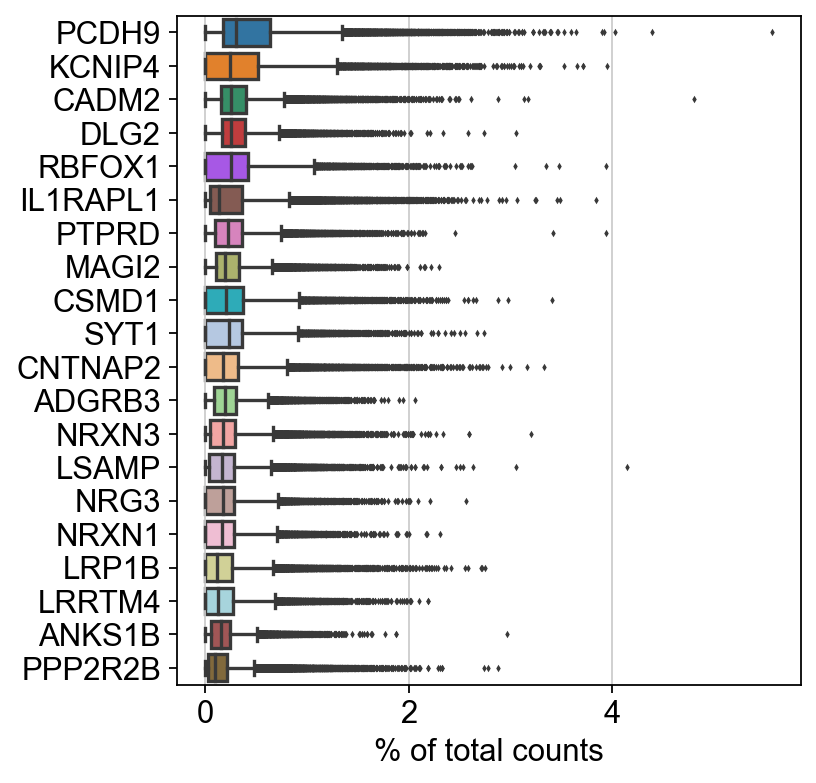

In [99]:
sc.pl.highest_expr_genes(adata_fil, n_top=20, )

Basic filtering.

In [100]:
adata_fil

AnnData object with n_obs × n_vars = 70634 × 17926 
    var: 'gene_ids'

In [105]:
sc.pp.filter_cells(adata_fil, min_genes=200)
sc.pp.filter_genes(adata_fil, min_cells=2)

In [108]:
mito_genes = adata_fil.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata_fil.obs['percent_mito'] = np.sum(
    adata_fil[:, mito_genes].X, axis=1).A1 / np.sum(adata_fil.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata_fil.obs['n_counts'] = adata_fil.X.sum(axis=1).A1

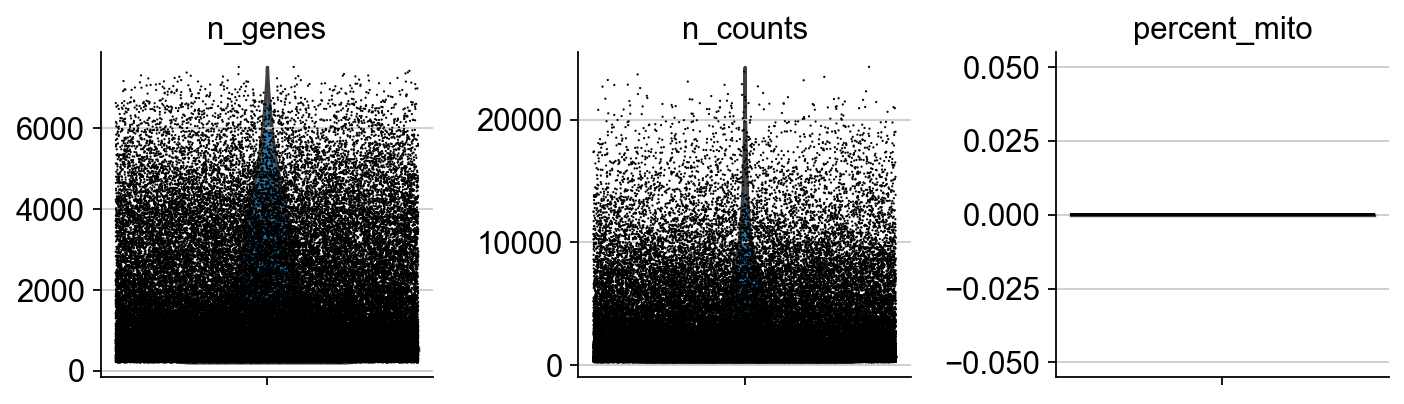

In [111]:
sc.pl.violin(adata_fil, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

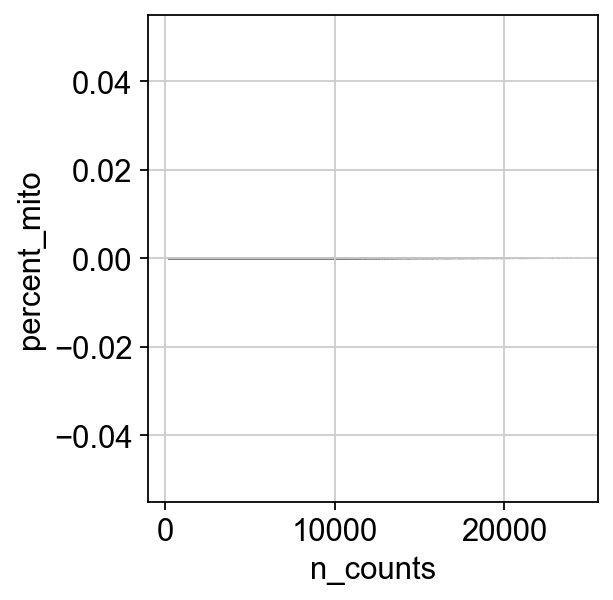

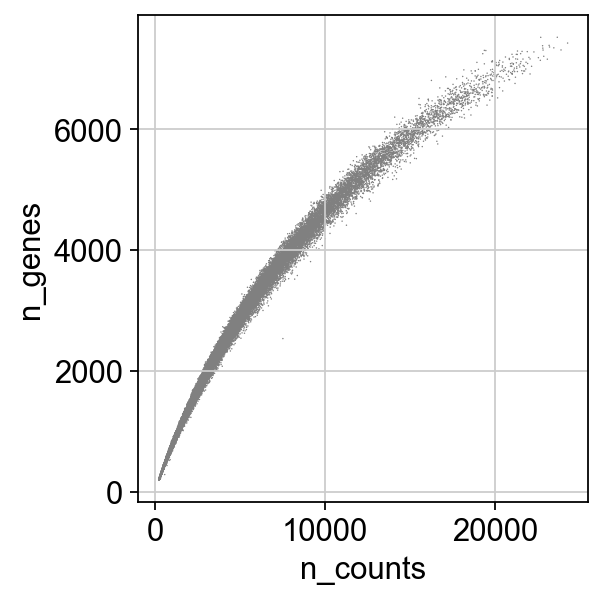

In [112]:
sc.pl.scatter(adata_fil, x='n_counts', y='percent_mito')
sc.pl.scatter(adata_fil, x='n_counts', y='n_genes')

In [177]:
adata_fil

AnnData object with n_obs × n_vars = 70634 × 3154 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

Actually do the filtering.

In [67]:
#adata_fil = adata_fil[adata_fil.obs.n_genes < 11000, :]
#adata_fil = adata_fil[adata_fil.obs.percent_mito < 0.375, :]

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [114]:
sc.pp.normalize_total(adata_fil, target_sum = 1e4 )

normalizing counts per cell
    finished (0:00:01)


Logarithmize the data.

In [115]:
sc.pp.log1p(adata_fil)

Set the `.raw` attribute of AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

While many people consider the normalized data matrix as the "relevant data" for visualization and differential testing, some would prefer to store the unnormalized data in `.raw`.

In [116]:
adata_fil.raw = adata_fil

<div class="alert alert-info">

**Note**
    
If you don't proceed below with correcting the data with `sc.pp.regress_out` and scaling it via `sc.pp.scale`, you can also get away without using `.raw` at all.

The result of the following highly-variable-genes detection is stored as an annotation in `.var.highly_variable` and auto-detected by PCA and hence, `sc.pp.neighbors` and subsequent manifold/graph tools. In that case, the step *actually do the filtering* below is unnecessary, too.

</div>

Identify highly-variable genes.

In [117]:
sc.pp.highly_variable_genes(adata_fil, min_mean = 0.0125 , max_mean = 3 , min_disp = 0.5)

extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


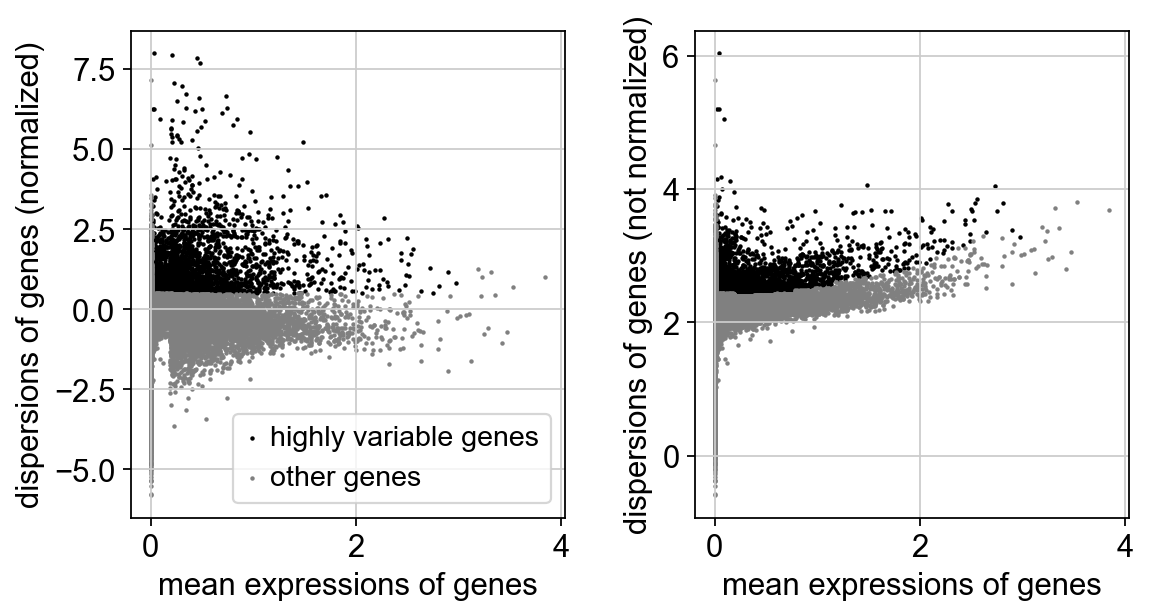

In [89]:
sc.pl.highly_variable_genes(adata_fil)

Actually do the filtering.

In [118]:
adata_fil = adata_fil[:, adata_fil.var.highly_variable]

In [119]:
adata_fil

View of AnnData object with n_obs × n_vars = 70634 × 3154 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [120]:
sc.pp.regress_out(adata_fil, ['n_counts'])

regressing out ['n_counts']
    sparse input is densified and may lead to high memory use
    finished (0:04:58)


Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [121]:
sc.pp.scale(adata_fil, max_value=10)


In [122]:
adata_fil

AnnData object with n_obs × n_vars = 70634 × 3154 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [123]:
sc.tl.pca(adata_fil, svd_solver='arpack')

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:28)


We can make a scatter plot in the PCA coordinates, but we will not use that later on.

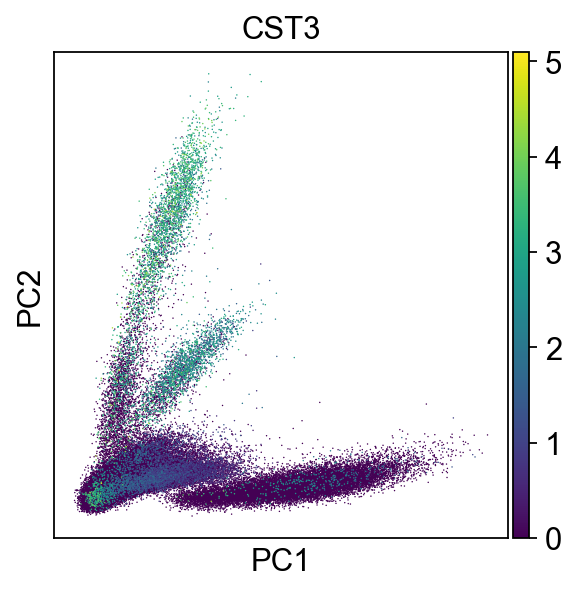

In [124]:
sc.pl.pca(adata_fil, color='CST3')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine.

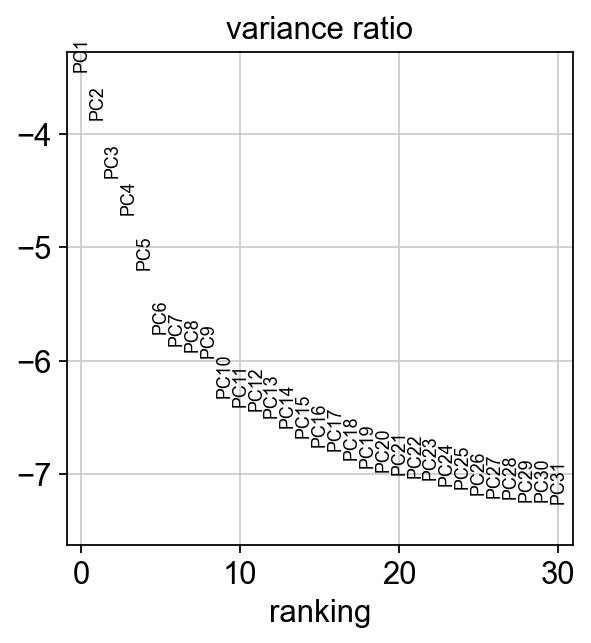

In [125]:
sc.pl.pca_variance_ratio(adata_fil, log=True)

Save the result.

In [127]:
adata_fil.write(results_file)

In [128]:
adata_fil

AnnData object with n_obs × n_vars = 70634 × 3154 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [129]:
sc.pp.neighbors(adata_fil, n_neighbors=30, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:01:31)


## Embedding the neighborhood graph

We advertise embedding the graph in 2 dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is  potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preservers trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```

In [130]:
sc.tl.umap(adata_fil)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:57)


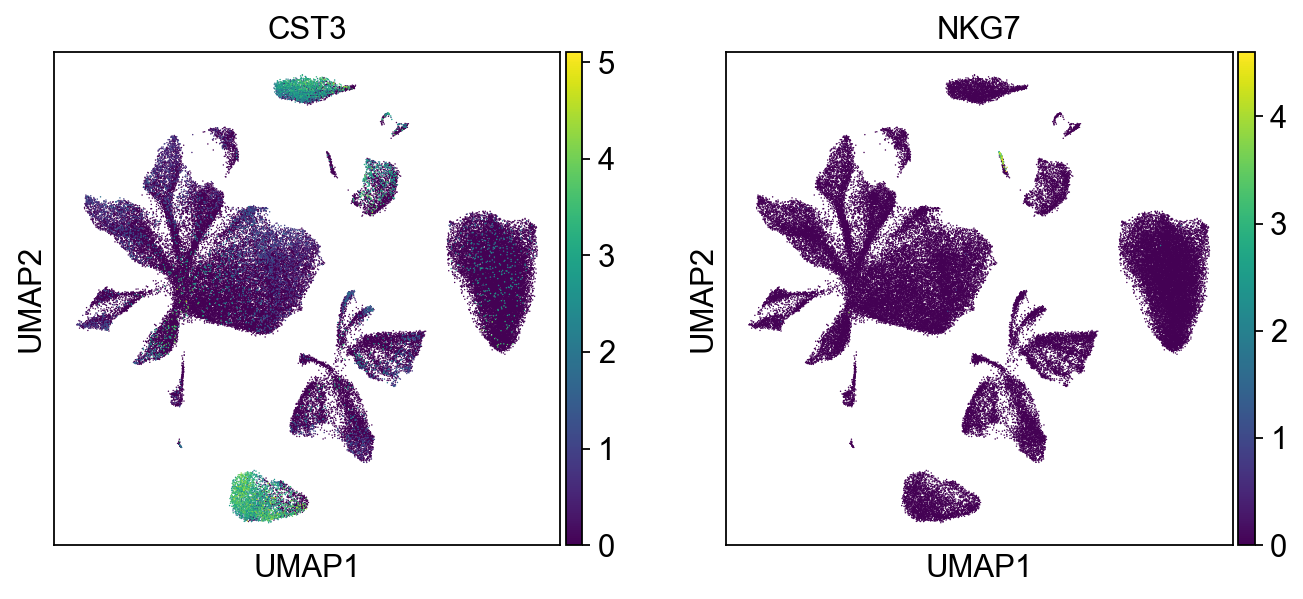

In [133]:
sc.pl.umap(adata_fil, color=['CST3', 'NKG7'])

As we set the `.raw` attribute of `adata`, the previous plots showed the "raw" (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

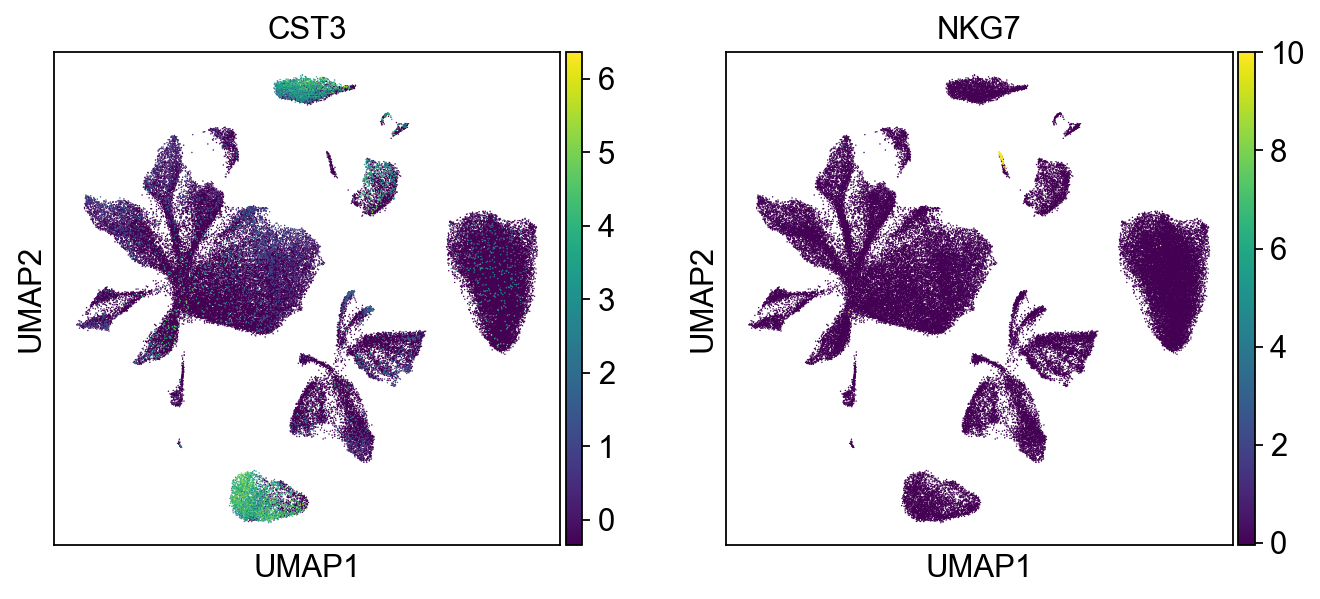

In [134]:
sc.pl.umap(adata_fil, color=['CST3', 'NKG7'], use_raw=False)

## Clustering the neighborhood graph

As Seurat and many others, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by [Traag *et al.* (2018)](https://scanpy.readthedocs.io/en/latest/references.html#traag18). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [136]:
sc.tl.leiden(adata_fil)

running Leiden clustering
    finished: found 22 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:02:13)


Plot the clusters, which agree quite well with the result of Seurat.

In [176]:
values, counts = np.unique(adata_fil.obs.leiden, return_counts=True)
values
(counts)

array([11638,  7295,  2751,  2629,  2016,  1836,  1752,  1668,  1012,
         692,   433,   400,  6600,   288,   181,  6411,  5110,  4661,
        3540,  3396,  3217,  3108])

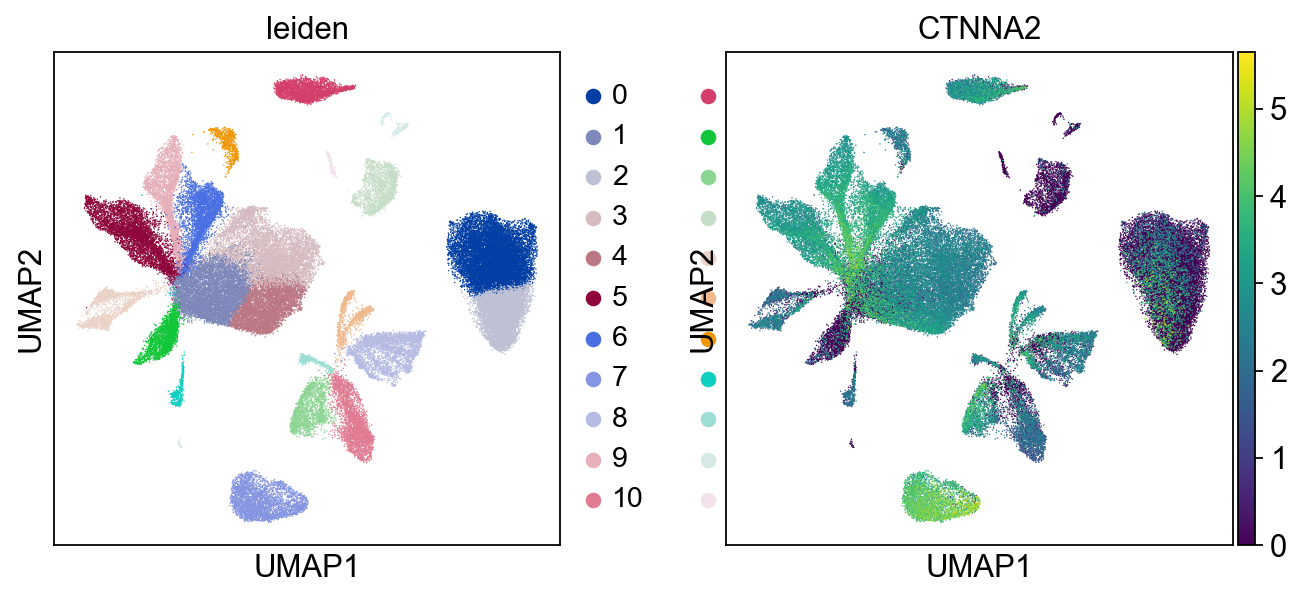

In [140]:
sc.pl.umap(adata_fil, color=['leiden','CTNNA2'])

Save the result.

In [141]:
adata_fil.write(results_file)

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:32)


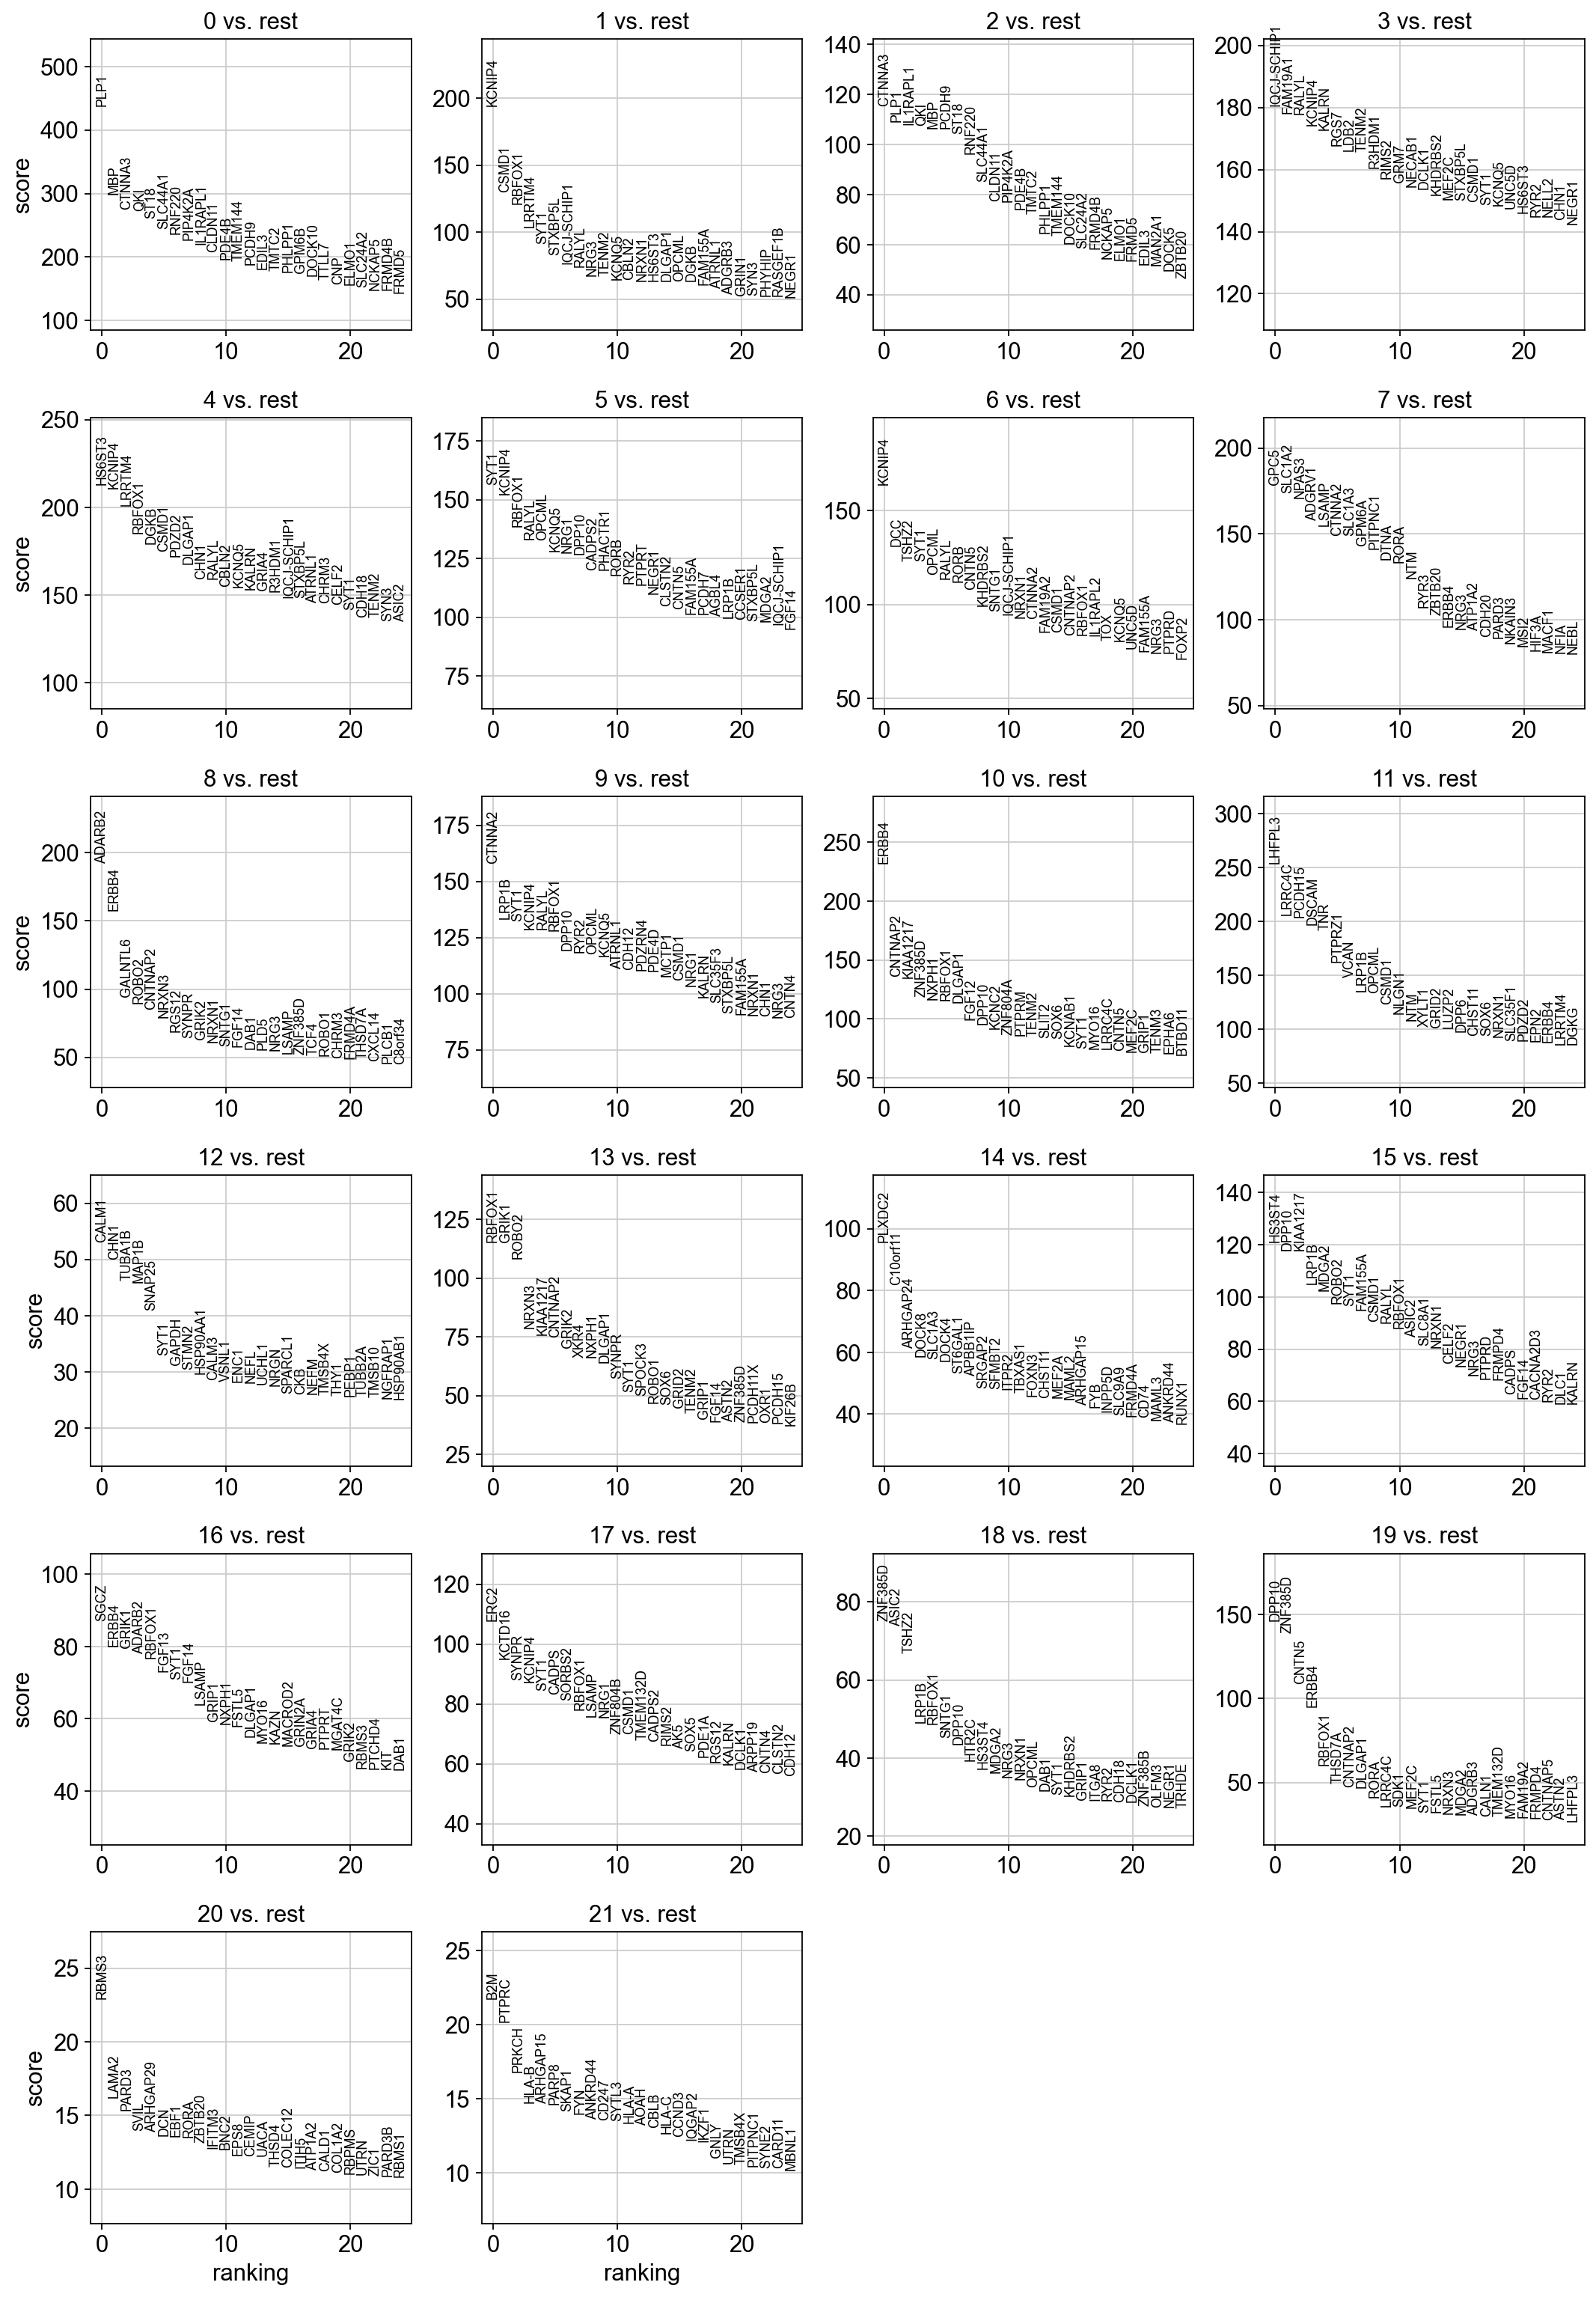

In [143]:
sc.tl.rank_genes_groups(adata_fil, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata_fil, n_genes=20, sharey=False)

In [144]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://de.wikipedia.org/wiki/Wilcoxon-Mann-Whitney-Test) test is very similar. We recommend using the latter in publications, see e.g., [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished (0:03:24)


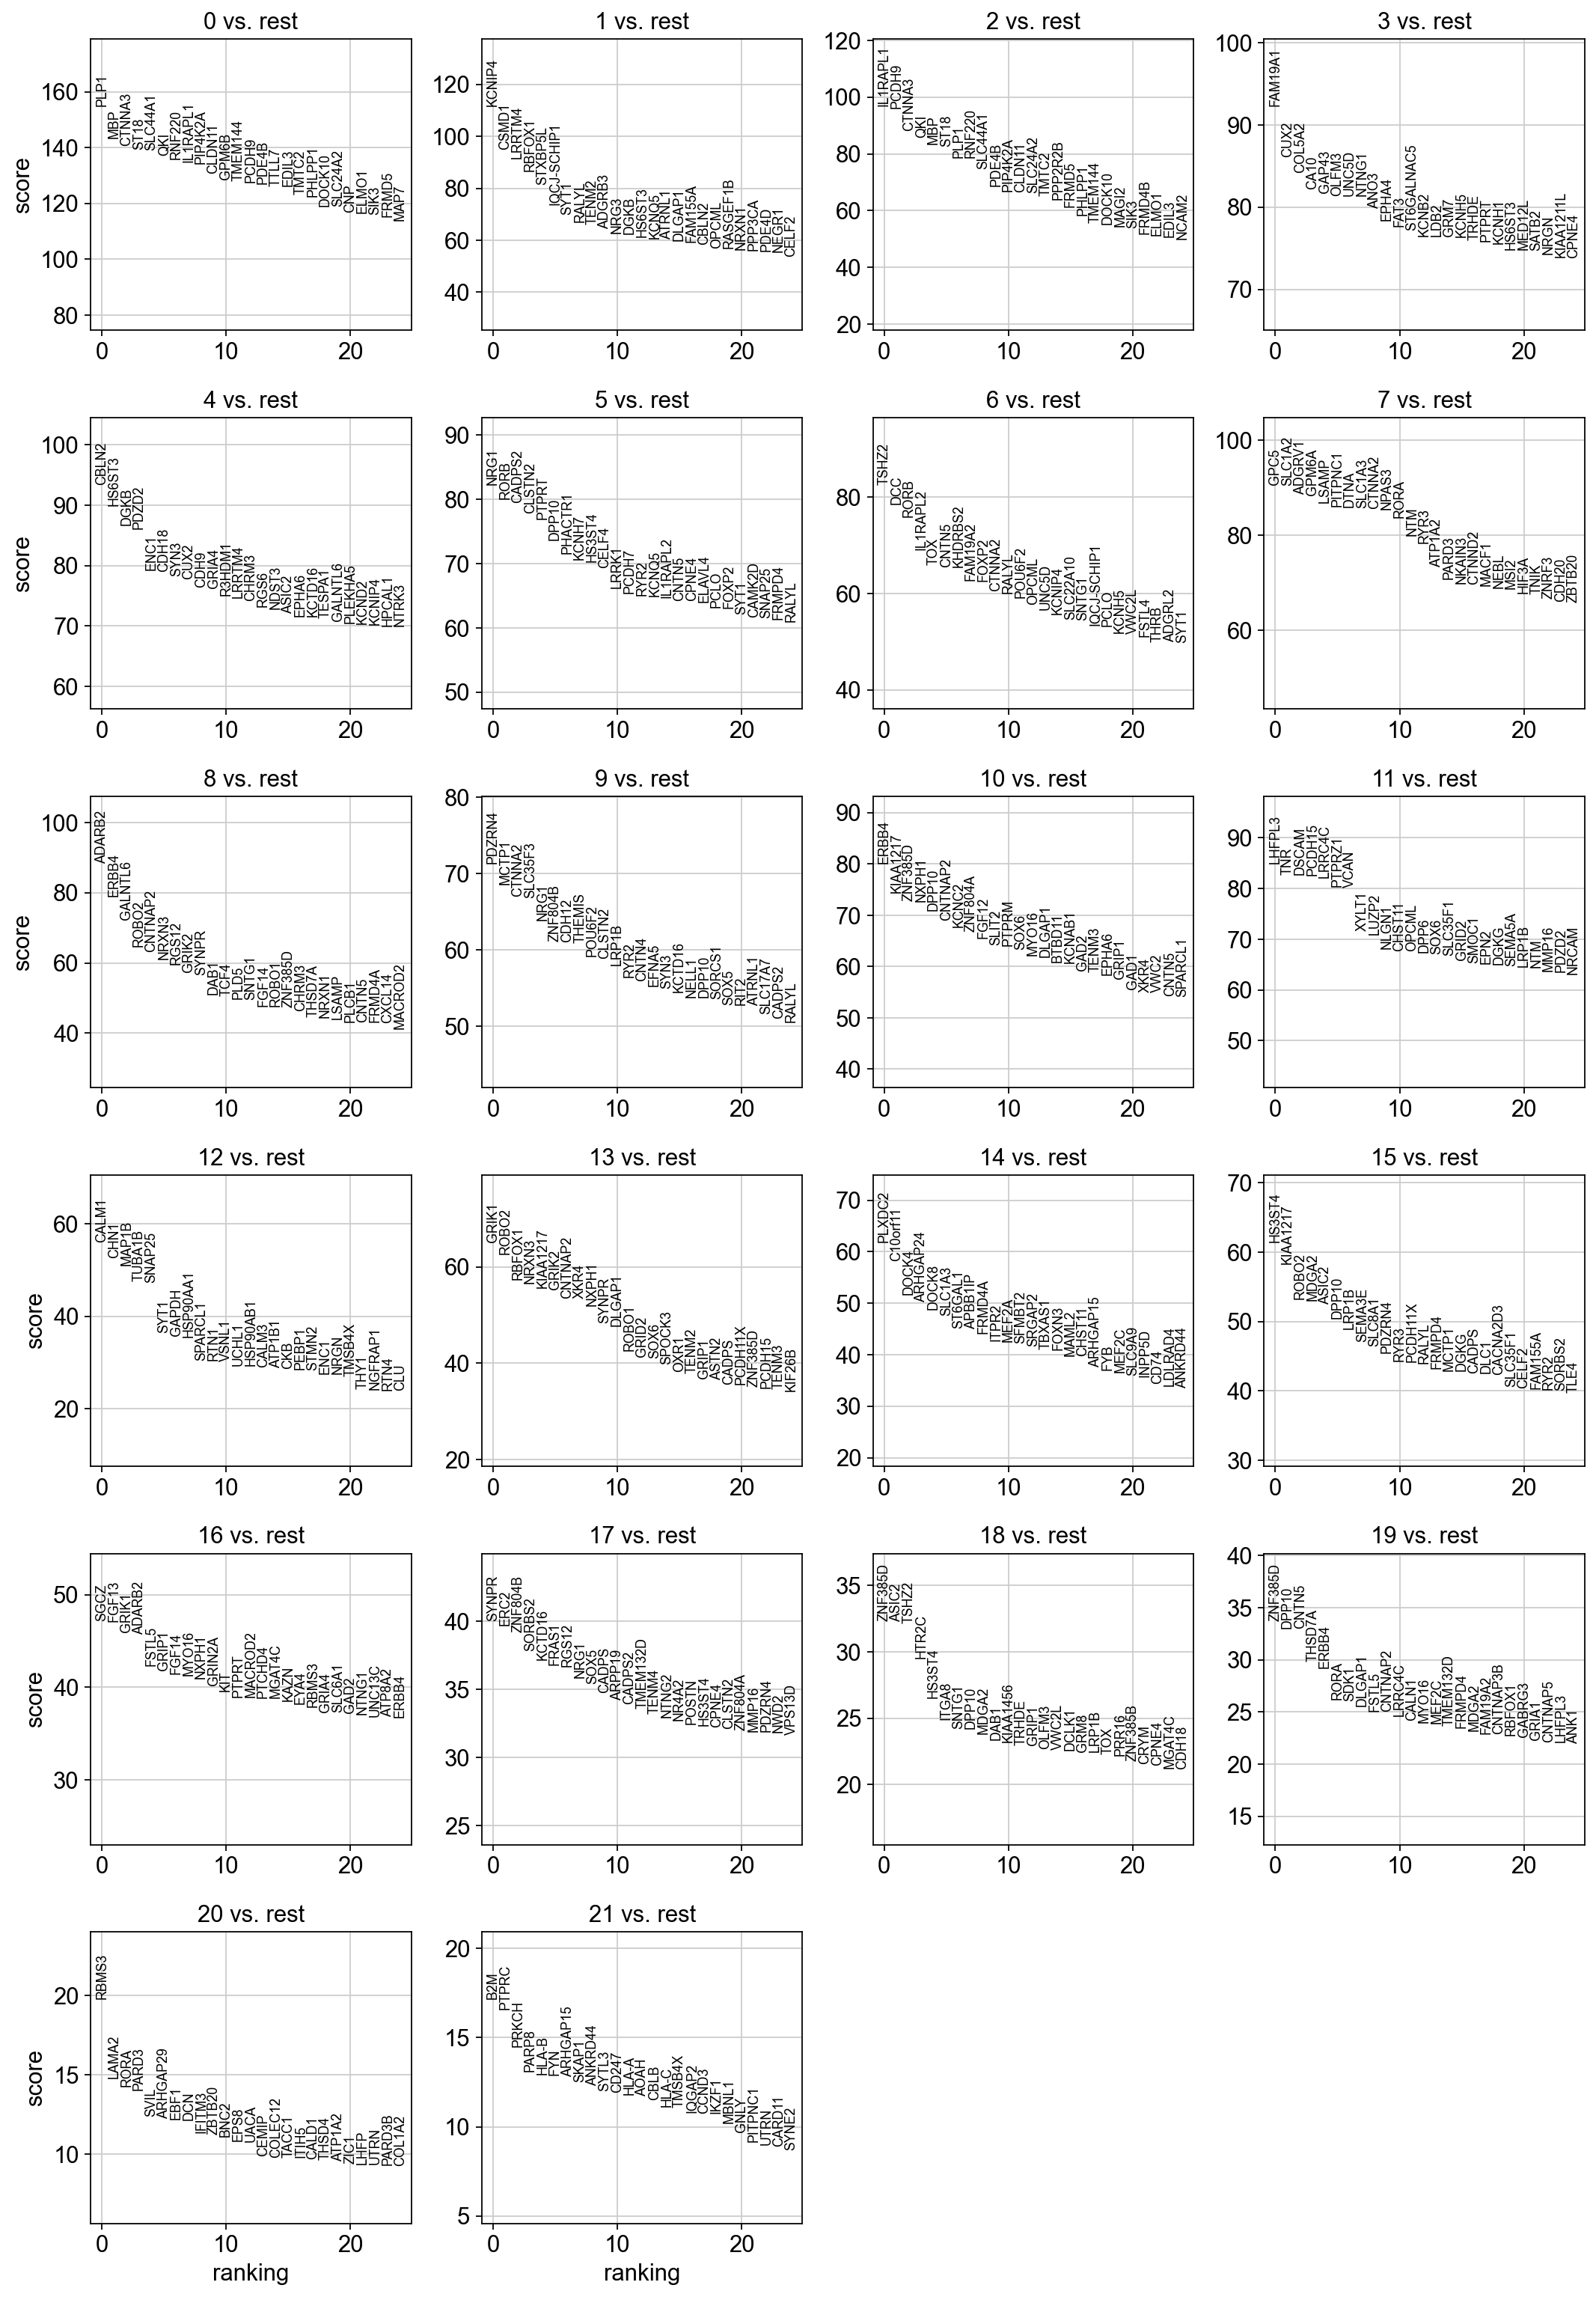

In [145]:
sc.tl.rank_genes_groups(adata_fil, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata_fil, n_genes=20, sharey=False)

Save the result.

In [146]:
adata_fil.write(results_file)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos et al. (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate approach whereas conventional differential tests are uni-variate. [Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79) has more details.

ranking genes
    finished (0:12:00)


/Users/subhajit/miniconda3/envs/scRNA_test/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


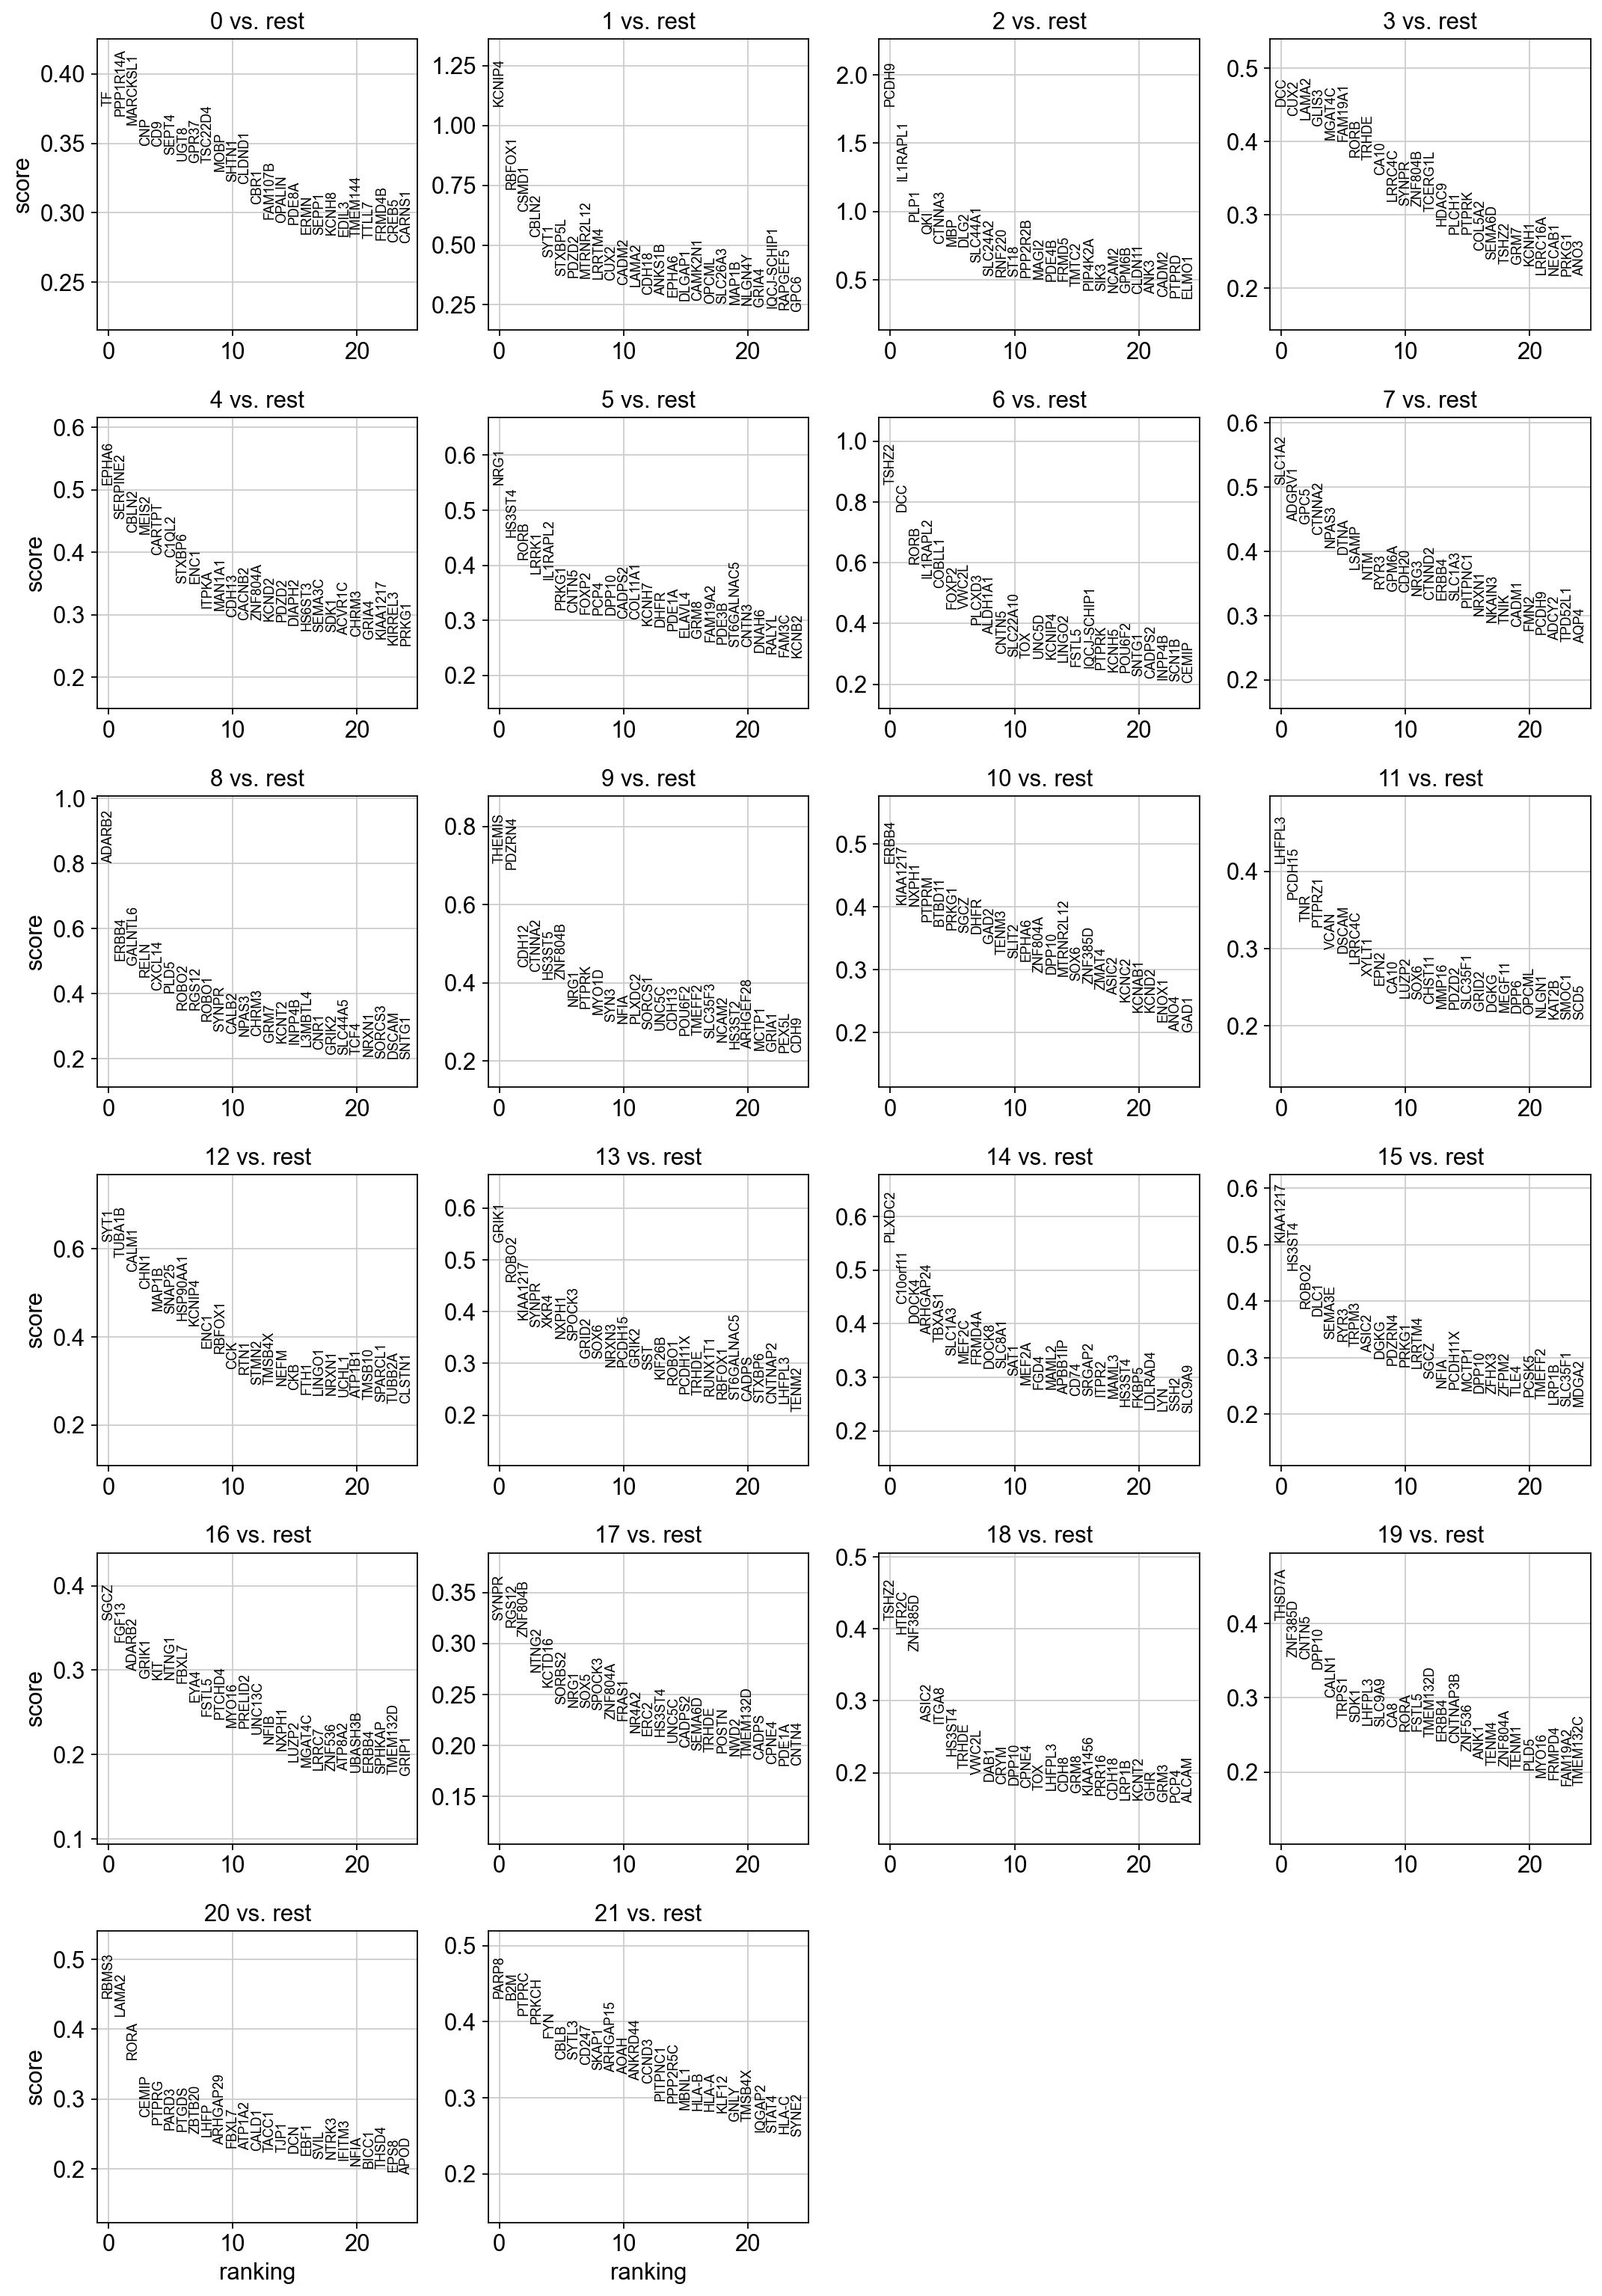

In [147]:
sc.tl.rank_genes_groups(adata_fil, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata_fil, n_genes=25, c=False)

With the exceptions of *IL7R*, which is only found by the t-test and *FCER1A*, which is only found by the other two appraoches, all marker genes are recovered in all approaches.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

Let us also define a list of marker genes for later reference.

In [191]:
marker_genes = ['PLP1', 'KCNIP4', 'IL1RAPL1', 'FAM19A1', 'CBLN2', 'NRG1', 'TSHZ2',
                'GPC5','ADARB2', 'PDZRN4', 'ERBB4','LHFPL3',
                'CALM1','GRIK1', 'PLXDC2', 'HS3ST4','SGCZ','SYNPR',
                'ZNF385D','ZNF385D','RBMS3','B2M']
                

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [163]:
adata_fil = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, ..., 21 in a dataframe.

In [164]:
pd.DataFrame(adata_fil.uns['rank_genes_groups']['names']).head(5)

0        1         2        3       4       5         6       7  \
0     PLP1   KCNIP4  IL1RAPL1  FAM19A1   CBLN2    NRG1     TSHZ2    GPC5   
1      MBP    CSMD1     PCDH9     CUX2  HS6ST3    RORB       DCC  SLC1A2   
2   CTNNA3   LRRTM4    CTNNA3   COL5A2    DGKB  CADPS2      RORB  ADGRV1   
3     ST18   RBFOX1       QKI     CA10   PDZD2  CLSTN2  IL1RAPL2   GPM6A   
4  SLC44A1  STXBP5L       MBP    GAP43    ENC1   PTPRT       TOX   LSAMP   

         8        9  ...      12        13        14        15      16  \
0   ADARB2   PDZRN4  ...   CALM1     GRIK1    PLXDC2    HS3ST4    SGCZ   
1    ERBB4    MCTP1  ...    CHN1     ROBO2  C10orf11  KIAA1217   FGF13   
2  GALNTL6   CTNNA2  ...   MAP1B    RBFOX1     DOCK4     ROBO2   GRIK1   
3    ROBO2  SLC35F3  ...  TUBA1B     NRXN3  ARHGAP24     MDGA2  ADARB2   
4  CNTNAP2     NRG1  ...  SNAP25  KIAA1217     DOCK8     ASIC2   FSTL5   

        17       18       19     20     21  
0    SYNPR  ZNF385D  ZNF385D  RBMS3    B2M  
1     ERC2    ASIC2    DPP10  LAMA2  PTPRC  
2  ZNF804B    TSHZ2    CNTN5   RORA  PRKCH  
3   SORBS2    HTR2C   THSD7A  PARD3  PARP8  
4   KCTD16   HS3ST4    ERBB4   SVIL  HLA-B  

[5 rows x 22 columns]

Get a table with the scores and groups.

In [150]:
result = adata_fil.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n  0_p      1_n  1_p       2_n  2_p      3_n  3_p     4_n  4_p  ...  \
0     PLP1  0.0   KCNIP4  0.0  IL1RAPL1  0.0  FAM19A1  0.0   CBLN2  0.0  ...   
1      MBP  0.0    CSMD1  0.0     PCDH9  0.0     CUX2  0.0  HS6ST3  0.0  ...   
2   CTNNA3  0.0   LRRTM4  0.0    CTNNA3  0.0   COL5A2  0.0    DGKB  0.0  ...   
3     ST18  0.0   RBFOX1  0.0       QKI  0.0     CA10  0.0   PDZD2  0.0  ...   
4  SLC44A1  0.0  STXBP5L  0.0       MBP  0.0    GAP43  0.0    ENC1  0.0  ...   

      17_n           17_p     18_n           18_p     19_n           19_p  \
0    SYNPR   0.000000e+00  ZNF385D  1.222304e-229  ZNF385D  1.223645e-249   
1     ERC2   0.000000e+00    ASIC2  1.107602e-228    DPP10  2.875700e-239   
2  ZNF804B   0.000000e+00    TSHZ2  6.662105e-227    CNTN5  1.762379e-238   
3   SORBS2   0.000000e+00    HTR2C  4.828288e-191   THSD7A  1.102645e-195   
4   KCTD16  7.539548e-302   HS3ST4  3.804271e-155    ERBB4  4.733829e-187   

    20_n          20_p   21_n          21_p  
0  RBMS3  7.415735e-87    B2M  6.400433e-66  
1  LAMA2  2.311702e-49  PTPRC  9.783490e-62  
2   RORA  5.071551e-46  PRKCH  1.812065e-47  
3  PARD3  1.611532e-44  PARP8  4.405063e-39  
4   SVIL  5.684423e-35  HLA-B  3.069526e-38  

[5 rows x 44 columns]

Compare to a single cluster. 

ranking genes
    finished (0:00:29)


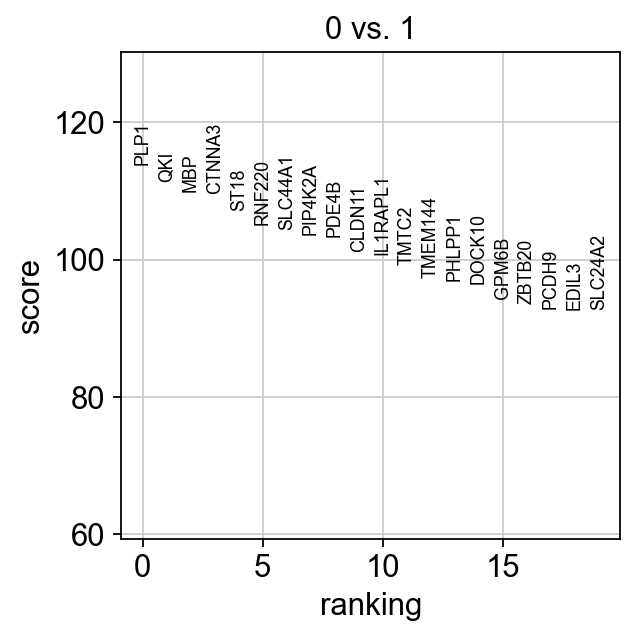

In [151]:
sc.tl.rank_genes_groups(adata_fil, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata_fil, groups=['0'], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

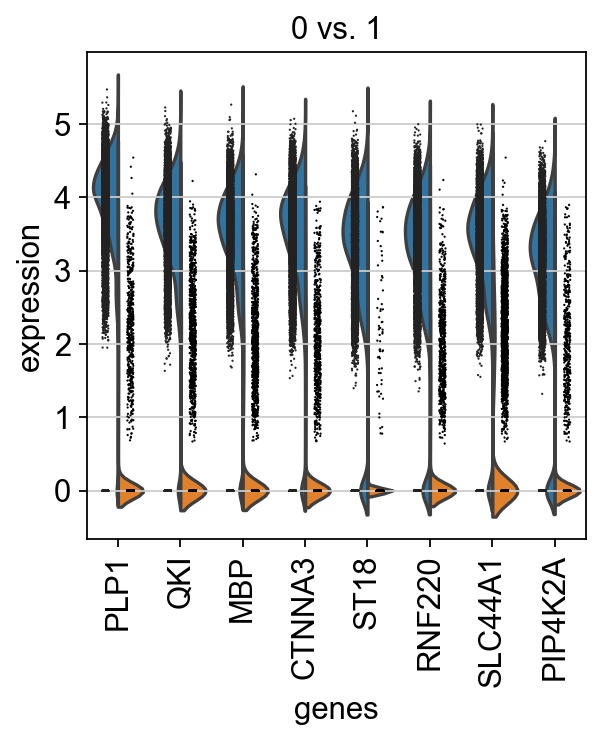

In [152]:
sc.pl.rank_genes_groups_violin(adata_fil, groups='0', n_genes=8)

Reload the object that computed differential expression by comparing to the rest of the groups.

In [153]:
adata_fil = sc.read(results_file)

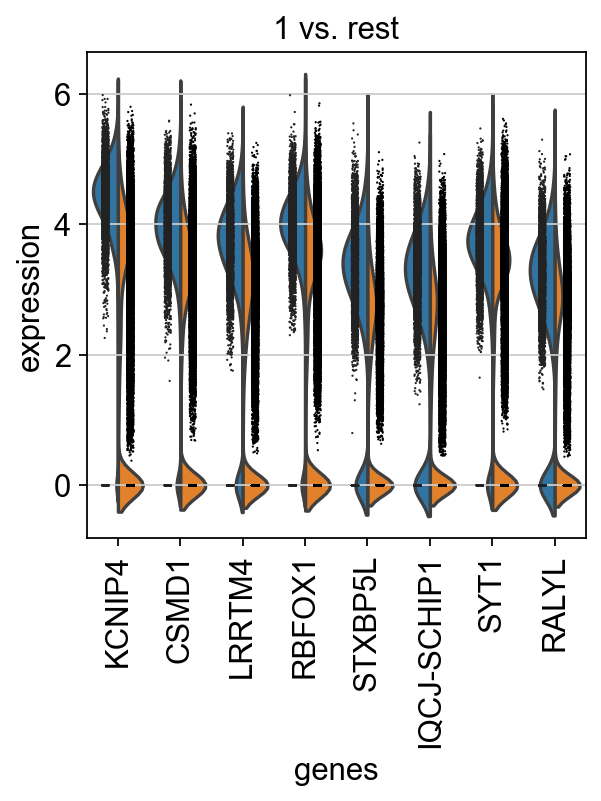

In [156]:
sc.pl.rank_genes_groups_violin(adata_fil, groups='1', n_genes=8)

If you want to compare a certain gene across groups, use the following.

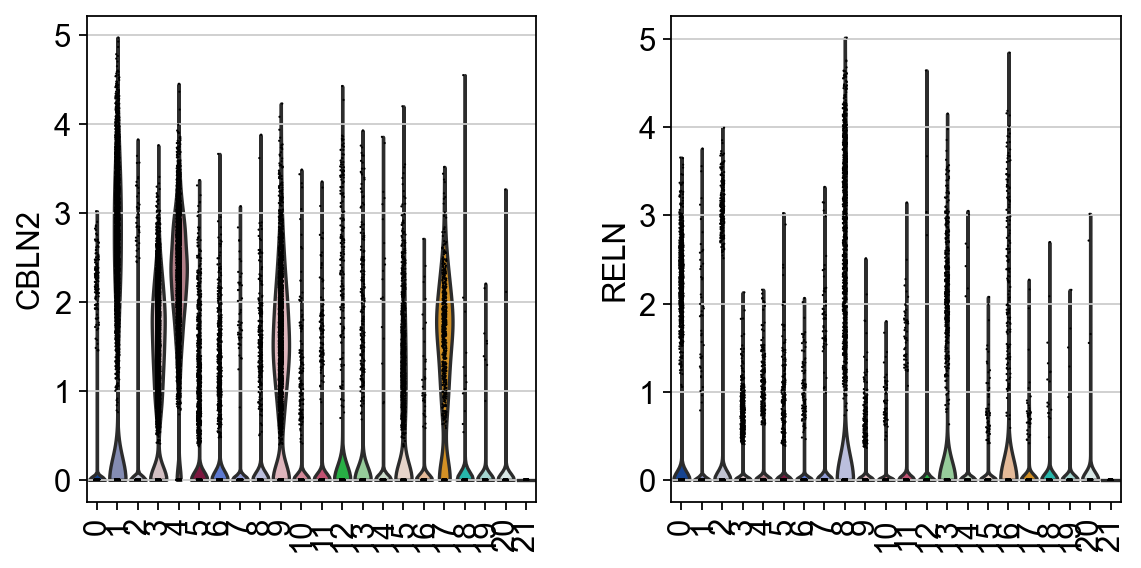

In [166]:
sc.pl.violin(adata_fil, ['CBLN2', 'RELN'], groupby='leiden', rotation=90)

Actually mark the cell types.

In [178]:
new_cluster_names = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6','C7', 'C8', 'C9', 'C10', 'C11', 'C12',
                    'C13', 'C14', 'C15', 'C16','C17', 'C18', 'C19', 'C20', 'C21', 'C22']
adata_fil.rename_categories('leiden', new_cluster_names)

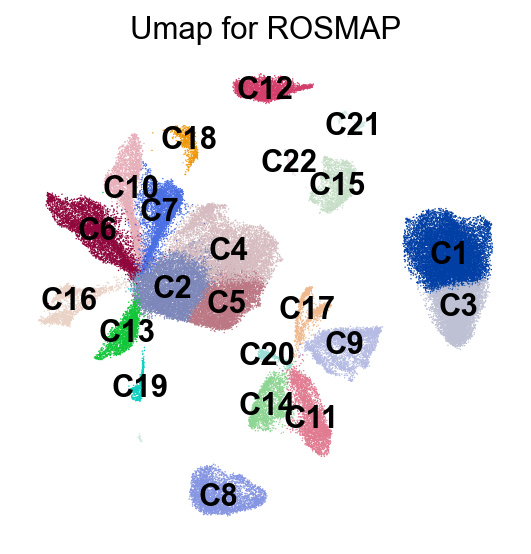

In [199]:
sc.pl.umap(adata_fil, color='leiden', legend_loc='on data', title='Umap for ROSMAP', frameon=False)

Now that we annotated the cell types, let us visualize the marker genes.

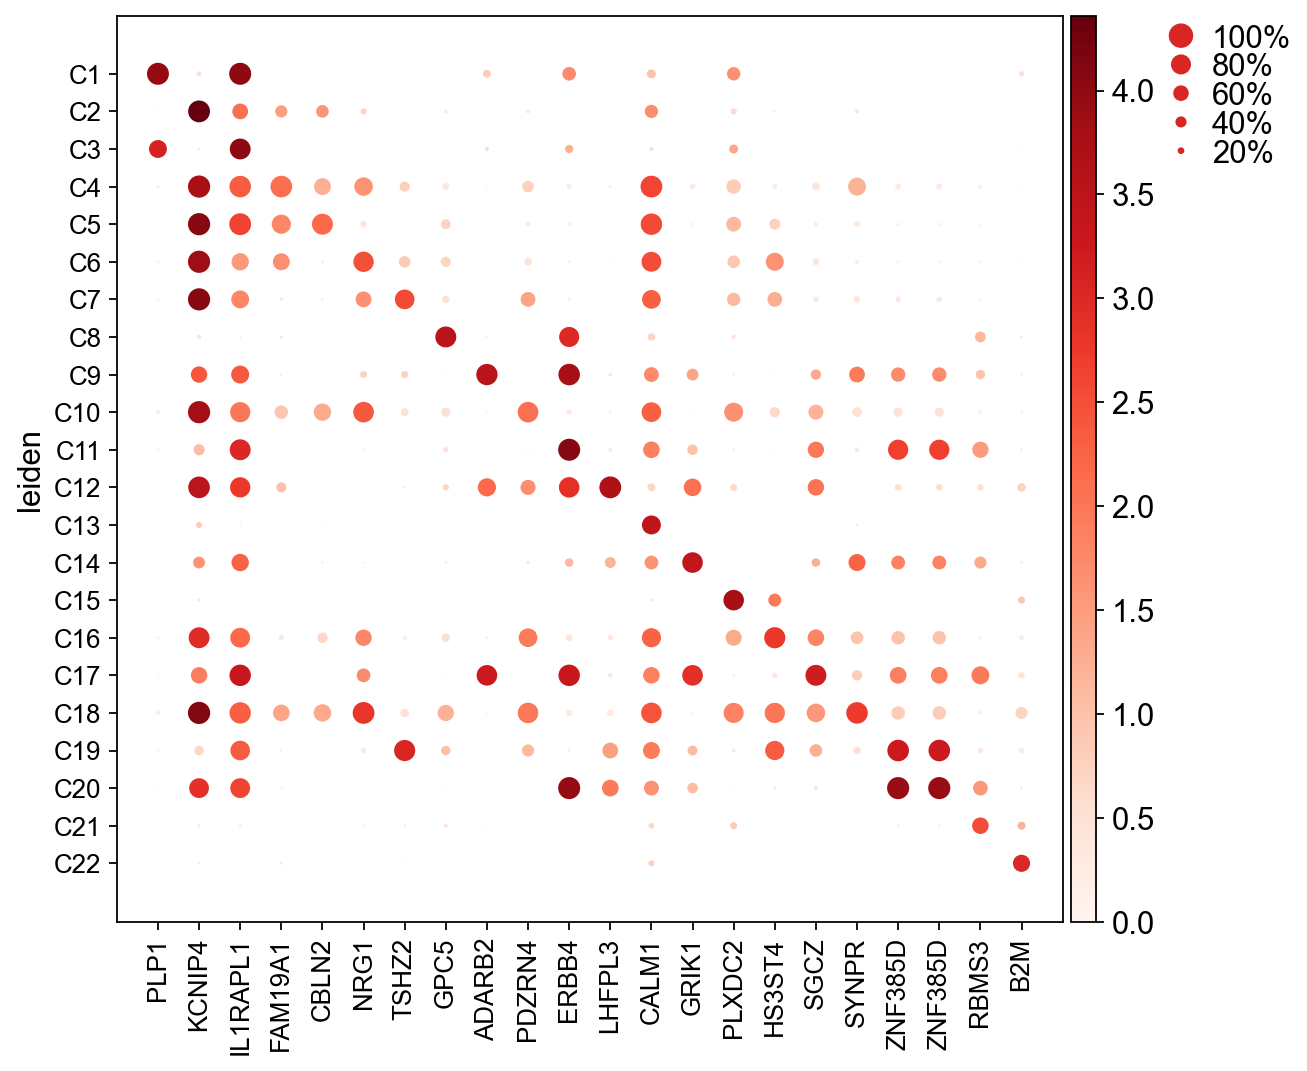

In [192]:
ax = sc.pl.dotplot(adata_fil, marker_genes, groupby='leiden')

There is also a very compact violin plot.

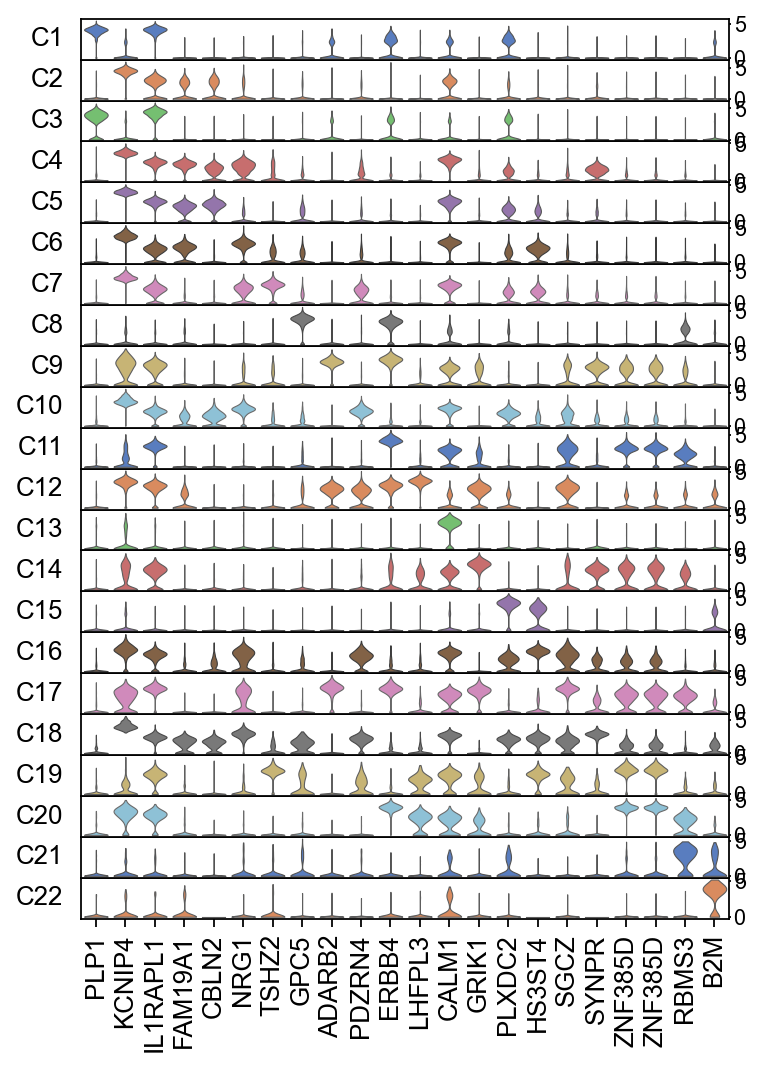

In [193]:
ax = sc.pl.stacked_violin(adata_fil, marker_genes, groupby='leiden', rotation=90)

During the course of this analysis, the AnnData accumlated the following annotations.

In [196]:
adata_fil

AnnData object with n_obs × n_vars = 70634 × 3154 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [197]:
adata_fil.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

OSError: Unable to create file (unable to lock file, errno = 35, error message = 'Resource temporarily unavailable')

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations.

In [198]:
adata_fil.X = None
adata_fil.write('./write/rosmap_scRNA_withoutX.h5ad', compression='gzip')

ValueError: Data matrix has wrong shape (), need to be (70634, 3154).

If you want to export to "csv", you have the following options:

In [56]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )